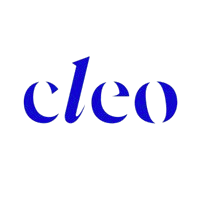

### **Parcours Makers - Module 1 - Prompt engineering avancé**
##**Cours 2 : Explorer plusieurs pistes avec Tree of Thoughts**

Comment générer une idée vraiment percutante sans rester bloqué sur la première intuition ? Ce notebook vous invite à explorer une approche plus structurée du raisonnement créatif grâce à Tree of Thoughts. En s’appuyant sur LangChain, LangGraph et quelques outils Python, vous apprendrez à construire, évaluer et comparer plusieurs solutions possibles à un problème marketing.

Chaque étape est commentée pour guider la compréhension, illustrer les apports concrets de l’approche arborescente et encourager un regard critique sur les résultats produits.

Dans ce cas pratique, vous endossez le rôle d’un·e responsable marketing chargé·e de créer un slogan pour une marque éthique. Entre créativité, contraintes de communication et critères d’impact, il ne s’agit pas seulement d’avoir une bonne idée mais de choisir la meilleure parmi plusieurs alternatives.

Grâce à Tree of Thoughts, vous pourrez :
- Générer des propositions à partir de différents angles de communication ;
- Attribuer un score à chaque piste selon des critères explicites (impact, pertinence écologique, mémorisation) ;
- Comparer et justifier le choix final en retraçant le cheminement des idées.


## 1. Préparer l’environnement

Avant de commencer, assurons-nous que toutes les bibliothèques nécessaires sont bien installées et que l'accès à l'API OpenAI est configuré.

Exécutez la cellule suivante **une seule fois** pour installer les bibliothèques utilisées dans ce notebook :


In [ ]:
# ↳ à exécuter une seule fois
!pip install -q \
    langchain==0.3.26 \
    langgraph==0.5.3 \
    openai==1.97.0 \
    python-dotenv==1.1.1 \
    tiktoken==0.9.0 \
    pandas==2.2.2 \
    langchain-openai==0.3.28

Cette cellule importe les modules nécessaires, charge les variables d’environnement, et vous demande une clé OpenAI si elle n’est pas déjà définie.

In [ ]:
from dotenv import load_dotenv
import os, openai, tiktoken, pandas as pd
from getpass import getpass

load_dotenv()                              # charge un éventuel .env
if "OPENAI_API_KEY" not in os.environ:     # invite si la variable manque
    os.environ["OPENAI_API_KEY"] = getpass("🔑 Entrer votre clé OpenAI : ")

import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

model_name = "gpt-4o-mini"
enc = tiktoken.encoding_for_model("gpt-4o-mini")

🔑 Entrer votre clé OpenAI : ··········


**Remarque** : ce notebook utilise le modèle `gpt-4o-mini`, mais vous pouvez adapter à un autre modèle (ex. gpt-4) si besoin.

## 2. Construction des outils ToT avec LangChain

Nous commençons par initialiser un modèle de langage via LangChain pour générer et évaluer des propositions textuelles.  

Ici, nous utilisons `gpt-4o-mini` avec une température modérée afin de favoriser la créativité tout en gardant une certaine cohérence.

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model=model_name, temperature=0.7)

### 2.1. Génération d’alternatives créatives

Pour explorer plusieurs pistes de communication, nous avons besoin d’un outil capable de générer rapidement différentes versions d’un slogan à partir d’un prompt.

La fonction suivante produit un nombre donné de slogans concis et sans justification, prêts à être comparés.

In [ ]:
def expand(prompt: str, n: int = 3) -> list[str]:
    """
    Produit n slogans à partir d'un prompt.

    Args:
        prompt: Le prompt à partir duquel générer les slogans.
        n: Le nombre de slogans à générer (par défaut : 3).

    Returns:
        Une liste de slogans générés.
    """

    # Construit la question pour le modèle de langage
    q = (
        prompt
        + f"\n\nGénère exactement {n} slogans concis, un par ligne, sans explication."
    )

    # Appelle le modèle de langage et divise la réponse en lignes
    lines = llm.invoke(q).content.strip().splitlines()

    # Nettoie chaque ligne (supprime les tirets, espaces blancs) et filtre les lignes vides
    return [l.strip("- ").strip() for l in lines if l.strip()]

### 2.2. Évaluation des slogans : scoring hybride

L’arbre de pensées repose non seulement sur la génération d’options, mais aussi sur leur évaluation rigoureuse.

Ici, nous combinons deux approches :
- un **scoring LLM** basé sur des critères marketing explicites (impact, durabilité, mémorisation) ;
- un **ajustement heuristique** introduisant des règles métier simples (longueur, mots-clés).



#### Score LLM

In [ ]:
def llm_score(text: str) -> float:
    """
    Utilise un modèle de langage pour évaluer un slogan selon trois critères pondérés :
    - Impact émotionnel (40 %)
    - Mention du caractère durable (40 %)
    - Capacité de mémorisation (20 %)
    Retourne un score sur 10.
    """

    # Définition du prompt envoyé au modèle pour l’évaluation
    q = (
        "Note ce slogan sur 10 selon : impact émotionnel (40 %), mention claire du "
        "caractère durable (40 %), mémorisation (20 %). Ne renvoie que le nombre."
    )

    # Envoie du prompt et du slogan au modèle, récupération de la réponse sous forme de texte brut
    note = llm.invoke(q + f"\n\nSlogan : « {text} »").content.strip()

    # Vérifie si la réponse est un nombre valide, puis le convertit en float ; sinon retourne 0.0
    return float(note) if note.replace('.', '', 1).isdigit() else 0.0

#### Pénalité heuristique

In [ ]:
def heuristic_penalty(text: str) -> float:
    """
    Pénalise les slogans selon deux critères :
    - longueur excessive (> 6 mots)
    - absence du mot-clé 'nature'
    """

    # Si le slogan dépasse 6 mots, on ajoute une pénalité de +1
    length_penalty = 1 if len(text.split()) > 6 else 0

    # Si le mot 'nature' n'est pas présent, pas de bonus ; sinon, on réduit la pénalité (-0.5)
    keyword_bonus = 0 if "nature" not in text.lower() else -0.5

    # Score final = pénalité de longueur + bonus/malus lié au mot-clé
    return length_penalty + keyword_bonus


#### Score final

In [ ]:
def score(text: str) -> float:
    """Score final = note LLM – pénalité métier (plus haut = meilleur)."""

    # Calcule le score LLM pour le texte donné
    llm_s = llm_score(text)

    # Calcule la pénalité heuristique pour le texte donné
    heuristic_p = heuristic_penalty(text)

    # Retourne le score final (score LLM moins la pénalité heuristique)
    return llm_s - heuristic_p

## 3. Implémentation du raisonnement arborescent

Dans cette section, nous implémentons deux stratégies classiques d'exploration d'arbre : **Breadth-First Search** (BFS) et **Depth-First Search** (DFS).

Objectif : explorer différentes pistes créatives et identifier la séquence de slogans la plus prometteuse en maximisant le score moyen.

Aucune dépendance externe n’est requise ici : tout est codé à la main pour bien comprendre le fonctionnement de l’algorithme.

In [ ]:
def run_tot(prompt_root: str,
            branching: int = 3,
            depth: int = 2,
            algo: str = "bfs") -> tuple[list[tuple[str, float]], float, list[dict]]:
    """
    Exécute un raisonnement arborescent selon l’algorithme spécifié (bfs ou dfs).
    Retourne :
    - best_path : chemin optimal trouvé
    - best_score : score moyen du chemin optimal
    - trace : historique complet de l’exploration
    """

    trace = []  # Liste de toutes les pensées générées, avec leur niveau et score
    best_path, best_score = None, -1  # Initialisation du chemin et du score optimal

    frontier = [(prompt_root, [])]  # Pile ou file d’attente des nœuds à explorer : (prompt_actuel, chemin_actuel)

    for level in range(depth):  # Pour chaque niveau dans la profondeur maximale autorisée

        if algo == "dfs" and frontier:
            # Exploration en profondeur : LIFO
            prompt, path = frontier.pop()
            ideas = expand(prompt, branching)  # Génère n idées à partir du prompt

            for idea in ideas:
                s = score(idea)  # Calcule le score de l’idée
                trace.append({"niveau": level, "slogan": idea, "score": s})
                new_path = path + [(idea, s)]  # Met à jour le chemin avec cette idée
                front_node = (prompt + f"\nRéférence : {idea}", new_path)
                frontier.append(front_node)  # Ajoute à la pile (profondeur d’abord)

                # Mise à jour du meilleur chemin trouvé
                avg = sum(x[1] for x in new_path) / len(new_path)
                if avg > best_score:
                    best_score, best_path = avg, new_path

        else:
            # Exploration en largeur : BFS
            new_frontier = []
            for prompt, path in frontier:
                ideas = expand(prompt, branching)  # Génère n idées à partir du prompt
                for idea in ideas:
                    s = score(idea)
                    trace.append({"niveau": level, "slogan": idea, "score": s})
                    new_path = path + [(idea, s)]
                    new_prompt = prompt + f"\nRéférence : {idea}"
                    new_frontier.append((new_prompt, new_path))

            # Tri des branches par score moyen décroissant
            new_frontier.sort(key=lambda e: sum(x[1] for x in e[1]) / len(e[1]), reverse=True)
            frontier = new_frontier[:branching]  # On garde les meilleures branches
            best_path = frontier[0][1]
            best_score = sum(s for _, s in best_path) / len(best_path)

    return best_path, best_score, trace


## 4. Comparaison des résultats entre BFS et DFS

Nous allons maintenant tester l’algorithme `run_tot` sur un prompt marketing et comparer les deux approches.

In [ ]:
# Prompt initial de génération
root_prompt = (
    "Nous devons créer un slogan pour une boisson naturelle sans plastique, à destination "
    "des 18-25 ans. Propose d'abord trois slogans courts."
)

# Exécution de l’algorithme avec BFS
path_bfs, score_bfs, trace_bfs = run_tot(root_prompt, branching=3, depth=5, algo="bfs")

# Exécution de l’algorithme avec DFS
path_dfs, score_dfs, trace_dfs = run_tot(root_prompt, branching=3, depth=5, algo="dfs")

### 4.1. Résultats de l’approche BFS

In [ ]:
print("BFS → Meilleur chemin")
for i, (s, sc) in enumerate(path_bfs, 1):
    print(f"Étape {i} : {s}  (score {sc:.1f})")
print(f"Score moyen : {score_bfs:.2f}")

BFS → Meilleur chemin
Étape 1 : 3. "Frais, pur, sans déchet !"  (score 7.0)
Étape 2 : 1. "Naturellement bon, zéro déchet !"  (score 8.5)
Étape 3 : 1. "Éveille tes sens, préserve la planète !"  (score 7.0)
Étape 4 : "Bois responsable, vis durable !"  (score 8.0)
Étape 5 : "Nature en bouteille, zéro plastique !"  (score 8.5)
Score moyen : 7.80


### 4.2. Résultats de l’approche DFS

In [ ]:
print("\nDFS → Meilleur chemin")
for i, (s, sc) in enumerate(path_dfs, 1):
    print(f"Étape {i} : {s}  (score {sc:.1f})")
print(f"Score moyen : {score_dfs:.2f}")


DFS → Meilleur chemin
Étape 1 : 1. "Sirote la nature, pas le plastique !"  (score 7.5)
Score moyen : 7.50


### 4.3. Visualisation des scores explorés

Le graphique ci-dessous montre la répartition des scores générés par les deux algorithmes à chaque niveau de l’arbre. Cela permet d’observer leurs dynamiques d’exploration.

Questions critiques à se poser :
- Les scores se concentrent-ils aux premiers niveaux ou montent-ils en profondeur ?
- Le pruning de BFS élimine-t-il trop tôt des idées originales ?
- DFS consomme-t-il plus de tokens sans réel gain ?

In [ ]:
# Import de Plotly Express pour une visualisation rapide et interactive
import plotly.express as px

# Construction d’un DataFrame combiné avec les traces BFS et DFS
df_trace = pd.DataFrame(trace_bfs + trace_dfs)

# Ajout d’une colonne 'algo' pour différencier les deux stratégies dans le graphique
df_trace['Algo'] = ['BFS'] * len(trace_bfs) + ['DFS'] * len(trace_dfs)

# Création d’un boxplot pour visualiser la distribution des scores par niveau et par algorithme
fig = px.box(
    df_trace,
    x="niveau",           # Axe des niveaux dans l’arbre
    y="score",            # Score des slogans
    color="Algo",         # Couleur selon l’algorithme (BFS ou DFS)
    title="Distribution des scores par niveau / algorithme",
    template="plotly_white"
)

# Personnalisation des titres des axes
fig.update_layout(
    xaxis_title="Niveau dans l'arbre",
    yaxis_title="Score"
)

# Affichage du graphique interactif
fig.show()


## Pour aller plus loin

- **Paramétrage** : vous pouvez modifier branching, depth, temperature et mesurer l’impact sur la diversité et le temps de réponse.
- **Scoring custom** : remplacez l’heuristique heuristic_penalty par un calcul de similarité d’embedding pour favoriser l’originalité.
- **Logging avancé** : exportez la trace complète (prompt partiel, score, coût token) pour un audit détaillé.
- **Guardrails** : ajoutez un filtre LangChain OutputParser pour interdire tout slogan de plus de 40 caractères.
- **MCTS simplifié** : implémentez une fonction de sélection probabiliste (exploration / exploitation) et comparez avec BFS/DFS.



## Conclusion

En résumé, Tree of Thoughts permet d’explorer des idées de manière structurée, en stimulant la créativité tout en conservant un cadre d’évaluation rigoureux. Le scoring hybride, combinant modèle de langage et règles métier, assure un équilibre entre subjectivité et contraintes opérationnelles. Le choix d’algorithme (BFS, DFS, MCTS) a un impact direct sur le coût en tokens et la qualité des résultats, d’où l’importance de bien le calibrer. En intégrant traçabilité et visualisation, cette approche devient un véritable levier d’idéation responsable, adaptable à différents contextes et exigences.
